# Notebook 5: Multi-Agent Orchestration

## Learning Objectives
- Understand multi-agent patterns
- Implement the Supervisor pattern
- Build a team of specialized agents
- Explore other orchestration patterns

## Why Multi-Agent?

Single agents have limitations:
- **Context window limits**: One agent can't hold everything
- **Specialization**: Different tasks need different expertise
- **Parallelism**: Multiple agents can work simultaneously
- **Modularity**: Easier to update/replace individual agents

Multi-agent systems allow you to build **teams** of specialized agents working together.

In [25]:
import os
from dotenv import load_dotenv

load_dotenv()

from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from IPython.display import Image, display

llm = ChatOpenAI(model="gpt-5.1", temperature=0)

## Pattern 1: Supervisor Agent

The **Supervisor** pattern has a central agent that:
1. Receives user requests
2. Decides which worker agent to delegate to
3. Collects results and decides next steps
4. Returns final response

```
                    ┌─────────────┐
                    │  Supervisor │
                    └──────┬──────┘
              ┌────────────┼────────────┐
              ▼            ▼            ▼
        ┌──────────┐ ┌──────────┐ ┌──────────┐
        │ Researcher│ │  Coder   │ │  Writer  │
        └──────────┘ └──────────┘ └──────────┘
```

In [26]:
# Define the workers and their capabilities
WORKERS = {
    "researcher": "Expert at finding information, analyzing data, and providing facts.",
    "coder": "Expert at writing, reviewing, and explaining code.",
    "writer": "Expert at writing, editing, and formatting text content."
}

# Supervisor's routing decision
class RouteDecision(BaseModel):
    """Supervisor's decision on which worker to use"""
    next_worker: Literal["researcher", "coder", "writer", "FINISH"] = Field(
        description="The next worker to handle the task, or FINISH if done"
    )
    reasoning: str = Field(
        description="Brief explanation of why this worker was chosen"
    )

supervisor_llm = llm.with_structured_output(RouteDecision)

In [30]:
# Define the state
class TeamState(TypedDict):
    messages: Annotated[list, add_messages]
    next_worker: str
    task_complete: bool
    workers_used: list[str]  # Track which workers have contributed

# Supervisor node
def supervisor(state: TeamState) -> dict:
    """Supervisor decides which worker to delegate to"""
    
    worker_descriptions = "\n".join([f"- {name}: {desc}" for name, desc in WORKERS.items()])
    workers_used = state.get("workers_used", [])
    workers_used_str = ", ".join(workers_used) if workers_used else "none yet"
    
    system_prompt = f"""You are a supervisor managing a team of workers.
    
Available workers:
{worker_descriptions}

Workers that have already contributed: {workers_used_str}

IMPORTANT RULES:
1. Analyze the original user request carefully - identify ALL required tasks
2. Route to ONE worker at a time for their specific expertise
3. After each worker completes, check if MORE workers are needed
4. Only choose FINISH when ALL parts of the request have been addressed by the appropriate specialists
5. If the user asked for multiple things (e.g., "research X, then code Y, then document Z"), 
   make sure each specialist contributes before finishing

Based on the conversation, decide which worker should handle the NEXT step.
Never route to a already used worker again.
Choose FINISH only when the task is FULLY complete with all requested parts done."""
    
    decision = supervisor_llm.invoke([
        SystemMessage(content=system_prompt),
        *state["messages"]
    ])
    
    # Track workers used
    new_workers_used = workers_used.copy()
    if decision.next_worker != "FINISH" and decision.next_worker not in new_workers_used:
        new_workers_used.append(decision.next_worker)
    
    return {
        "next_worker": decision.next_worker,
        "task_complete": decision.next_worker == "FINISH",
        "workers_used": new_workers_used
    }

# Worker nodes - each focuses ONLY on their specialty
def researcher(state: TeamState) -> dict:
    """Research worker - finds information"""
    response = llm.invoke([
        SystemMessage(content="""You are a research specialist. 
ONLY provide research, facts, and analysis.
Do NOT write code or documentation - other specialists will handle those.
Be concise but thorough. Cite sources when possible.
Focus only on the research aspects of the request."""),
        *state["messages"]
    ])
    return {"messages": [AIMessage(content=f"[Researcher]: {response.content}")]}

def coder(state: TeamState) -> dict:
    """Coding worker - writes code"""
    response = llm.invoke([
        SystemMessage(content="""You are a coding specialist.
ONLY write code and explain implementation choices.
Do NOT do research or write user documentation - other specialists handle those.
Write clean, well-commented code.
Focus only on the coding aspects of the request."""),
        *state["messages"]
    ])
    return {"messages": [AIMessage(content=f"[Coder]: {response.content}")]}

def writer(state: TeamState) -> dict:
    """Writing worker - creates content"""
    response = llm.invoke([
        SystemMessage(content="""You are a writing specialist.
ONLY write documentation, articles, or other written content.
Do NOT write code or do research - other specialists handle those.
Create clear, engaging, well-structured content.
Focus only on the writing/documentation aspects of the request."""),
        *state["messages"]
    ])
    return {"messages": [AIMessage(content=f"[Writer]: {response.content}")]}

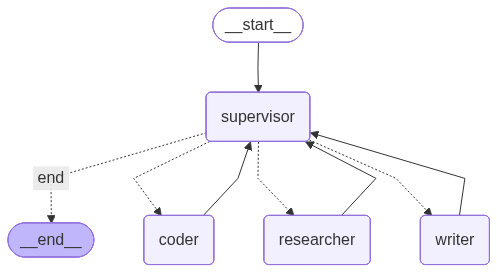

In [31]:
# Router function
def route_to_worker(state: TeamState) -> Literal["researcher", "coder", "writer", "end"]:
    """Route to the chosen worker or end"""
    if state["task_complete"] or state["next_worker"] == "FINISH":
        return "end"
    return state["next_worker"]

# Build the graph
builder = StateGraph(TeamState)

# Add nodes
builder.add_node("supervisor", supervisor)
builder.add_node("researcher", researcher)
builder.add_node("coder", coder)
builder.add_node("writer", writer)

# Add edges
builder.add_edge(START, "supervisor")

# Supervisor routes to workers
builder.add_conditional_edges(
    "supervisor",
    route_to_worker,
    {
        "researcher": "researcher",
        "coder": "coder",
        "writer": "writer",
        "end": END
    }
)

# All workers go back to supervisor
builder.add_edge("researcher", "supervisor")
builder.add_edge("coder", "supervisor")
builder.add_edge("writer", "supervisor")

team_graph = builder.compile()

display(Image(team_graph.get_graph().draw_mermaid_png()))

In [ ]:
# Test with a task that requires multiple workers
result = team_graph.invoke({
    "messages": [HumanMessage(content="""I need help creating a Python function that calculates 
    the Fibonacci sequence. First research the algorithm, then write the code, 
    and finally write documentation for it.""")],
    "next_worker": "",
    "task_complete": False,
    "workers_used": []
})

print("=== Team Collaboration ===")
print(f"Workers used: {result.get('workers_used', [])}\n")
for msg in result["messages"]:
    if isinstance(msg, HumanMessage):
        print(f"\nUser: {msg.content[:100]}...")
    else:
        print(f"\n{msg.content[:500]}..." if len(msg.content) > 500 else f"\n{msg.content}")

In [32]:
# Stream to see the flow
print("=== Streaming Team Execution ===")

for event in team_graph.stream({
    "messages": [HumanMessage(content="""I need help creating a Python function that returns all even numbers in a list. 
    First write the code, then research best practices for this problem, 
    and finally write documentation for it.""")],
    "next_worker": "",
    "task_complete": False,
    "workers_used": []
}):
    for node, output in event.items():
        print(f"\n--- {node.upper()} ---")
        if "next_worker" in output:
            print(f"Routing to: {output['next_worker']}")
        if "workers_used" in output:
            print(f"Workers used so far: {output['workers_used']}")
        if "messages" in output and output["messages"]:
            print(f"{output['messages'][-1].content[:300]}...")

=== Streaming Team Execution ===

--- SUPERVISOR ---
Routing to: coder
Workers used so far: ['coder']

--- CODER ---
[Coder]: ```python
from typing import Iterable, List


def get_even_numbers(numbers: Iterable[int]) -> List[int]:
    """
    Return a list containing only the even integers from the input iterable.

    Parameters
    ----------
    numbers : Iterable[int]
        Any iterable of integers (e.g., li...

--- SUPERVISOR ---
Routing to: researcher
Workers used so far: ['coder', 'researcher']

--- RESEARCHER ---
[Researcher]: Here is the research on best practices and documentation aspects for this small filtering function. I will not rewrite the code or documentation themselves, only analyze and justify design choices.

---

## 1. Design and implementation best practices

### 1.1. Core logic: filtering wit...

--- SUPERVISOR ---
Routing to: writer
Workers used so far: ['coder', 'researcher', 'writer']

--- WRITER ---
[Writer]: Below is documentation you can use for your fun

## Pattern 2: Agents with Tools

Each worker agent can have its own specialized tools.

In [33]:
# Research tools
@tool
def search_web(query: str) -> str:
    """Search the web for information.
    
    Args:
        query: Search query
    """
    # Simulated search results
    return f"Search results for '{query}': Found 3 relevant articles about the topic."

@tool
def analyze_data(data: str) -> str:
    """Analyze provided data.
    
    Args:
        data: Data to analyze
    """
    return f"Analysis complete: The data shows interesting patterns."

# Coding tools
@tool
def run_code(code: str) -> str:
    """Execute Python code and return the result.
    
    Args:
        code: Python code to execute
    """
    try:
        # Simulated execution (don't actually run arbitrary code!)
        return f"Code executed successfully. Output: [simulated output]"
    except Exception as e:
        return f"Error: {str(e)}"

@tool
def lint_code(code: str) -> str:
    """Check code for style issues.
    
    Args:
        code: Code to lint
    """
    return "Linting complete: No issues found."

research_tools = [search_web, analyze_data]
coding_tools = [run_code, lint_code]

print("Specialized tools defined for each agent")

Specialized tools defined for each agent


## Pattern 3: Hierarchical Agents

For complex systems, you can have **supervisors of supervisors**:

```
                    ┌──────────────────┐
                    │  Top Supervisor  │
                    └────────┬─────────┘
              ┌──────────────┼──────────────┐
              ▼              ▼              ▼
        ┌──────────┐  ┌──────────┐  ┌──────────┐
        │ Research │  │   Dev    │  │ Content  │
        │   Lead   │  │   Lead   │  │   Lead   │
        └────┬─────┘  └────┬─────┘  └────┬─────┘
          ┌──┴──┐       ┌──┴──┐       ┌──┴──┐
          ▼     ▼       ▼     ▼       ▼     ▼
        [workers]     [workers]     [workers]
```

In [34]:
# Example: Create a sub-graph for a research team

class ResearchTeamState(TypedDict):
    messages: Annotated[list, add_messages]
    next_agent: str

def research_lead(state: ResearchTeamState) -> dict:
    """Research team lead coordinates research tasks"""
    response = llm.invoke([
        SystemMessage(content="""You are the research team lead. 
        Coordinate research tasks and synthesize findings.
        Decide if you need the data analyst or fact checker."""),
        *state["messages"]
    ])
    return {"messages": [response]}

def data_analyst(state: ResearchTeamState) -> dict:
    """Analyzes data and statistics"""
    response = llm.invoke([
        SystemMessage(content="You are a data analyst. Analyze data and provide insights."),
        *state["messages"]
    ])
    return {"messages": [AIMessage(content=f"[Data Analyst]: {response.content}")]}

def fact_checker(state: ResearchTeamState) -> dict:
    """Verifies facts and sources"""
    response = llm.invoke([
        SystemMessage(content="You are a fact checker. Verify claims and check sources."),
        *state["messages"]
    ])
    return {"messages": [AIMessage(content=f"[Fact Checker]: {response.content}")]}

# This sub-graph could be used as a node in a larger graph
print("Hierarchical pattern demonstrated - sub-teams can be composed as nodes")

Hierarchical pattern demonstrated - sub-teams can be composed as nodes


## Pattern 4: Agent Handoffs

Agents can directly hand off to other agents without a central supervisor.

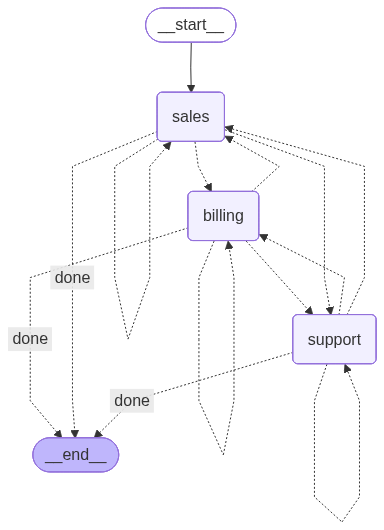

In [35]:
class HandoffState(TypedDict):
    messages: Annotated[list, add_messages]
    current_agent: str

class HandoffDecision(BaseModel):
    """Agent's decision to handle or handoff"""
    action: Literal["handle", "handoff"] = Field(
        description="Whether to handle the request or hand off to another agent"
    )
    handoff_to: Literal["sales", "support", "billing", "none"] = Field(
        description="Which agent to hand off to (if action is handoff)"
    )
    response: str = Field(
        description="Response to the user (if handling) or handoff message (if handing off)"
    )

handoff_llm = llm.with_structured_output(HandoffDecision)

def create_agent(name: str, specialty: str):
    """Factory function to create specialized agents"""
    
    def agent_fn(state: HandoffState) -> dict:
        decision = handoff_llm.invoke([
            SystemMessage(content=f"""You are the {name} agent, specializing in {specialty}.
            
            Available agents to hand off to:
            - sales: Product information, pricing, demos
            - support: Technical issues, troubleshooting
            - billing: Payments, invoices, refunds
            
            Either handle the request yourself or hand off to a more appropriate agent.
            Only hand off if the request is clearly outside your specialty."""),
            *state["messages"]
        ])
        
        if decision.action == "handoff" and decision.handoff_to != "none":
            return {
                "messages": [AIMessage(content=f"[{name}→{decision.handoff_to}]: {decision.response}")],
                "current_agent": decision.handoff_to
            }
        else:
            return {
                "messages": [AIMessage(content=f"[{name}]: {decision.response}")],
                "current_agent": "done"
            }
    
    return agent_fn

# Create agents
sales_agent = create_agent("Sales", "product information, pricing, and demos")
support_agent = create_agent("Support", "technical issues and troubleshooting")
billing_agent = create_agent("Billing", "payments, invoices, and refunds")

def route_handoff(state: HandoffState) -> str:
    current = state["current_agent"]
    if current == "done":
        return "end"
    return current

# Build graph
builder = StateGraph(HandoffState)

builder.add_node("sales", sales_agent)
builder.add_node("support", support_agent)
builder.add_node("billing", billing_agent)

# All agents can hand off to any other agent
for agent in ["sales", "support", "billing"]:
    builder.add_conditional_edges(
        agent,
        route_handoff,
        {"sales": "sales", "support": "support", "billing": "billing", "done": END, "end": END}
    )

# Start with sales (or could use a router)
builder.add_edge(START, "sales")

handoff_graph = builder.compile()

display(Image(handoff_graph.get_graph().draw_mermaid_png()))

In [36]:
# Test handoff
result = handoff_graph.invoke({
    "messages": [HumanMessage(content="I want to know about pricing, but I also have a billing issue with my last invoice.")],
    "current_agent": "sales"
})

print("=== Handoff Flow ===")
for msg in result["messages"]:
    print(f"{msg.content}\n")

=== Handoff Flow ===
I want to know about pricing, but I also have a billing issue with my last invoice.

[Sales→billing]: You’re asking about two things:
1) Pricing information (sales topic)
2) A billing issue with your last invoice (billing topic)

Because the billing issue requires access to invoices and payment details, I’ll bring in the **billing** agent, who can:
- Look into your last invoice
- Explain any unexpected charges
- Help with corrections, credits, or refunds if needed

While they’re joining, please share:
- Your account name or email on the account
- Invoice number (if you have it)
- A short description of what looks wrong on the invoice
- Your country/region (for tax/VAT context)

After they address the invoice issue, I can come back and walk you through **current pricing, discounts, and plan options** that best fit how you’re using the product.

[Billing→sales]: [Billing→sales]: The user has *two* needs:
1) General **pricing information** (sales topic)
2) A **billing

---

## Exercise 5: Build a Content Creation Team

Create a multi-agent system with:
1. **Supervisor**: Coordinates the team
2. **Ideator**: Generates content ideas and outlines
3. **Writer**: Writes the actual content
4. **Editor**: Reviews and improves the content

The system should:
- Take a topic and content type (blog, tweet, etc.)
- Have the ideator create an outline
- Have the writer create content based on the outline
- Have the editor polish it
- Return the final content

In [ ]:
# YOUR CODE HERE

class ContentState(TypedDict):
    messages: Annotated[list, add_messages]
    next_agent: str
    content_complete: bool

# TODO: Define supervisor

# TODO: Define ideator

# TODO: Define writer

# TODO: Define editor

# TODO: Build the graph

# Test:
# result = content_graph.invoke({
#     "messages": [HumanMessage(content="Create a tweet thread about the benefits of AI in healthcare")],
#     "next_agent": "",
#     "content_complete": False
# })

### Exercise 5: Solution (hidden)

<details>
<summary>Click to reveal solution</summary>

```python
class ContentRouting(BaseModel):
    next_agent: Literal["ideator", "writer", "editor", "FINISH"]
    reasoning: str

content_router = llm.with_structured_output(ContentRouting)

def content_supervisor(state: ContentState) -> dict:
    decision = content_router.invoke([
        SystemMessage(content="""You supervise a content creation team.
        - ideator: Creates outlines and ideas
        - writer: Writes content from outlines
        - editor: Polishes and improves content
        
        Route to FINISH when content is complete and polished."""),
        *state["messages"]
    ])
    return {
        "next_agent": decision.next_agent,
        "content_complete": decision.next_agent == "FINISH"
    }

def ideator(state: ContentState) -> dict:
    response = llm.invoke([
        SystemMessage(content="Create an outline and key ideas for the requested content."),
        *state["messages"]
    ])
    return {"messages": [AIMessage(content=f"[Ideator]: {response.content}")]}

def content_writer(state: ContentState) -> dict:
    response = llm.invoke([
        SystemMessage(content="Write content based on the provided outline and ideas."),
        *state["messages"]
    ])
    return {"messages": [AIMessage(content=f"[Writer]: {response.content}")]}

def editor(state: ContentState) -> dict:
    response = llm.invoke([
        SystemMessage(content="Review and polish the content. Make it engaging and error-free."),
        *state["messages"]
    ])
    return {"messages": [AIMessage(content=f"[Editor]: {response.content}")]}

def route_content(state: ContentState) -> str:
    if state["content_complete"]:
        return "end"
    return state["next_agent"]

builder = StateGraph(ContentState)
builder.add_node("supervisor", content_supervisor)
builder.add_node("ideator", ideator)
builder.add_node("writer", content_writer)
builder.add_node("editor", editor)

builder.add_edge(START, "supervisor")
builder.add_conditional_edges("supervisor", route_content, 
    {"ideator": "ideator", "writer": "writer", "editor": "editor", "end": END})
builder.add_edge("ideator", "supervisor")
builder.add_edge("writer", "supervisor")
builder.add_edge("editor", "supervisor")

content_graph = builder.compile()
```
</details>

---

## Prebuilt Multi-Agent Patterns

Now that you understand how multi-agent systems work under the hood, let's look at **prebuilt components** that simplify production code.

LangGraph provides two additional libraries for common multi-agent patterns:
- `langgraph-supervisor`: Prebuilt supervisor pattern
- `langgraph-swarm`: Prebuilt swarm/handoff pattern

These dramatically reduce boilerplate while providing the same functionality.

### Prebuilt Supervisor Pattern with `create_supervisor`

Remember the ~80 lines of code we wrote for the supervisor pattern above? Here's how to do the same thing with `langgraph-supervisor`:

```bash
pip install langgraph-supervisor
```

Note: As of LangGraph v1.0, `create_react_agent` has been moved to `langchain.agents.create_agent`.

Prebuilt supervisor created! Compare this to the manual implementation above.


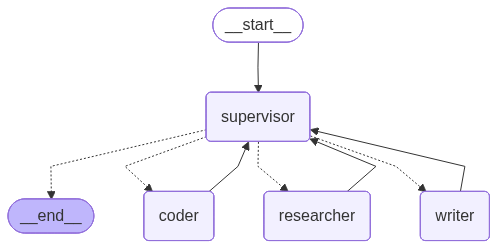

In [42]:
# Prebuilt Supervisor Pattern
# This replaces ~80 lines of manual code with ~30 lines!

from langchain.agents import create_agent
from langgraph_supervisor import create_supervisor
from langgraph.checkpoint.memory import MemorySaver

# Step 1: Create specialized worker agents using create_agent
prebuilt_researcher = create_agent(
    model=llm,
    tools=[],  # Could add research-specific tools here
    system_prompt="""You are a research specialist.
Provide accurate, well-researched information.
Be concise but thorough.""",
    name="researcher",
)

prebuilt_coder = create_agent(
    model=llm,
    tools=[],  # Could add coding-specific tools here
    system_prompt="""You are a coding specialist.
Write clean, well-commented code.
Explain your implementation choices.""",
    name="coder",
)

prebuilt_writer = create_agent(
    model=llm,
    tools=[],  # Could add writing-specific tools here
    system_prompt="""You are a writing specialist.
Create clear, engaging, well-structured content.""",
    name="writer",
)

# Step 2: Create supervisor with one function call!
prebuilt_supervisor = create_supervisor(
    model=llm,
    agents=[prebuilt_researcher, prebuilt_coder, prebuilt_writer],
    prompt=(
        "You are a supervisor managing a team of specialists:\n"
        "- researcher: Expert at finding information and analyzing data\n"
        "- coder: Expert at writing and reviewing code\n"
        "- writer: Expert at writing and editing content\n\n"
        "Assign work to the appropriate specialist based on the task."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile(checkpointer=MemorySaver())

print("Prebuilt supervisor created! Compare this to the manual implementation above.")

display(Image(prebuilt_supervisor.get_graph().draw_mermaid_png()))

In [41]:
# Test the prebuilt supervisor (same usage as manual version!)
# Note: When using a checkpointer, you must provide a thread_id
config = {"configurable": {"thread_id": "supervisor-test-1"}}

result = prebuilt_supervisor.invoke(
    {"messages": [HumanMessage(content="Write a short poem about Python programming.")]},
    config=config
)

print("=== Prebuilt Supervisor Result ===")
print(result["messages"][-1].content)

=== Prebuilt Supervisor Result ===
In a file of silent white,  
I whisper logic line by line,  
Snakes of syntax coil just right,  
Around a problem’s tangled spine.  

Indentation, soft and clean,  
Four small spaces, breathing room,  
From `if` and `else` to list’s new sheen,  
Ideas blossom, break and bloom.  

A loop that hums in gentle rounds,  
A function, named like spoken thought,  
In Python’s flow, the clacking sounds  
Turn puzzles into working plot.  

No semicolons, heavy chains,  
Just readable, like shared design—  
A common tongue in human brains,  
That lets our code and hope align.


### Prebuilt Swarm Pattern with `create_swarm`

For the handoff pattern (Pattern 4), there's `langgraph-swarm`:

```bash
pip install langgraph-swarm
```

The swarm pattern allows agents to hand off to each other using `create_handoff_tool`:

Prebuilt swarm created! Compare this to the manual handoff implementation above.


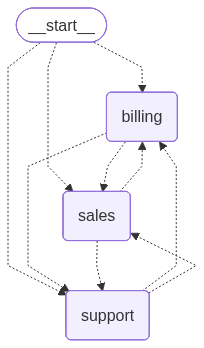

In [43]:
# Prebuilt Swarm Pattern
# This replaces ~70 lines of manual handoff code!

from langgraph_swarm import create_swarm, create_handoff_tool

# Step 1: Create handoff tools for each agent
transfer_to_support = create_handoff_tool(
    agent_name="support",
    description="Transfer to technical support for troubleshooting"
)
transfer_to_billing = create_handoff_tool(
    agent_name="billing",
    description="Transfer to billing for payment/invoice questions"
)
transfer_to_sales = create_handoff_tool(
    agent_name="sales",
    description="Transfer to sales for product info and pricing"
)

# Step 2: Create agents with their handoff tools
swarm_sales = create_agent(
    model=llm,
    tools=[transfer_to_support, transfer_to_billing],
    system_prompt="You are a sales agent. Handle product inquiries and pricing. Transfer to other agents when needed.",
    name="sales"
)

swarm_support = create_agent(
    model=llm,
    tools=[transfer_to_sales, transfer_to_billing],
    system_prompt="You are a support agent. Help with technical issues. Transfer to other agents when needed.",
    name="support"
)

swarm_billing = create_agent(
    model=llm,
    tools=[transfer_to_sales, transfer_to_support],
    system_prompt="You are a billing agent. Handle payment and invoice questions. Transfer to other agents when needed.",
    name="billing"
)

# Step 3: Create swarm with one function call!
swarm = create_swarm(
    agents=[swarm_sales, swarm_support, swarm_billing],
    default_active_agent="sales"
).compile()

print("Prebuilt swarm created! Compare this to the manual handoff implementation above.")
display(Image(swarm.get_graph().draw_mermaid_png()))

In [44]:
# Test the prebuilt swarm (same usage as manual version!)
result = swarm.invoke({
    "messages": [HumanMessage(content="I have a billing question about my last invoice.")]
})

print("=== Prebuilt Swarm Result ===")
for msg in result["messages"]:
    if hasattr(msg, 'content') and msg.content:
        print(f"{msg.content[:300]}..." if len(msg.content) > 300 else msg.content)

=== Prebuilt Swarm Result ===
I have a billing question about my last invoice.
Successfully transferred to billing
I can help with that.  

What’s the specific issue with your last invoice? For example:  
- Unexpected or incorrect charge  
- Missing discount or promotion  
- Tax/VAT issue  
- Wrong billing period or duplicate invoice  
- Need a detailed breakdown or copy of the invoice  

Please also share any r...


## Best Practices for Multi-Agent Systems

1. **Clear responsibilities**: Each agent should have a well-defined role
2. **Explicit handoffs**: Make it clear when and why agents transfer control
3. **Shared state**: Use state to pass context between agents
4. **Exit conditions**: Always have clear conditions to end the workflow
5. **Logging**: Add logging to track agent interactions
6. **Testing**: Test individual agents before combining them

## Summary: Choosing the Right Pattern

| Pattern | Use When | Pros | Cons |
|---------|----------|------|------|
| **Supervisor** | Clear task delegation needed | Centralized control, easy to reason about | Single point of failure |
| **Hierarchical** | Large, complex organizations | Scalable, modular | More complexity |
| **Handoff** | Peer-to-peer collaboration | Flexible, decentralized | Harder to track flow |
| **Parallel** | Independent subtasks | Faster execution | Coordination overhead |

## Congratulations!

You've completed the LangGraph workshop! You've learned:

1. **Basics**: State, Nodes, Edges, and building simple graphs
2. **Routing**: Conditional edges and dynamic flow control
3. **Tools**: Giving agents capabilities with tools
4. **Memory**: Persistence and multi-turn conversations
5. **Multi-Agent**: Orchestrating teams of specialized agents

### Next Steps

- Explore [LangGraph documentation](https://langchain-ai.github.io/langgraph/)
- Try [LangSmith](https://smith.langchain.com/) for debugging
- Build your own multi-agent applications!

Happy building!